<a href="https://colab.research.google.com/github/TanmayKhot/AI_project/blob/main/3_Indexing_and_Similarity_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indexing and Similarity Search

Now that we have the embeddings, the next step is to compare the embeddings and compute a similarity measure. This will be used to retreive images that are similar to the query image.



#### Similarity Measure

We use k-Nearest Neighbours along with cosine similarity measure to find similar images.

**kNN**: 

A k-nearest neighbors (k-NN) algorithm is a technique for performing similarity search: given a query data point, what are the k data points in an index that are most similar to the query? k-NN is largely popular for its use in content-based recommendation systems. The search assumes there is a  defined distance function between the feature vectors and returns most similar items to the one provided as input, where closest distance translates to item similarity.

**Cosine Similarity**:

Cosine Similarity is a measurement that quantifies the similarity between two or more vectors. The cosine similarity is the cosine of the angle between vectors. The vectors are typically non-zero and are within an inner product space.

The cosine similarity is described mathematically as the division between the dot product of vectors and the product of the euclidean norms or magnitude of each vector.

$$similarity = cos(\theta) = \frac{A.B}{||A|| ||B||}$$

$$ = \frac{\sum_{i=1}^N A_iB_i}{\sqrt{\sum_{i=1}^N A_i^2}\sqrt{\sum_{i=1}^N B_i^2}} $$




### Task 1: Loading the embeddings 

In this notebook we upload the previously locally computed embeddings and set up elastic search. We then load the embeddings we computed with facenet and resnet50 in EC2 and index them and finally query the top 10 faces given

## How to run this notebook and access the files in EC2

**Run Juputer in Deep learning AMI**

first connect through SSH, the public DNS change every time the server is stopped, the updated ones can find in the tab connection of the EC2 instance.
At the time of writing this documentation the following are the working commands.

1) Through terminal open the folder where the private key is stored:

`cd C:\Users\student\Documents\NYU Courses\AI`

2) SSH in the instance:
```
ssh -i "group7.pem" ubuntu@ec2-18-191-153-60.us-east-2.compute.amazonaws.com
```
3) activate the AWS deeplearning AMI:

```
source activate tensorflow2_p38
```
4) Run jupyter notebook selecting a free port and -no browser, then copy the link to access the notebook.
```
jupyter notebook --no-browser --port=8880
```
**Run Opensearch**

Now SSH into the instance again in another terminal window (repeat steps 1-3) and run Opensearch. We installed using Docker following this guide: https://opensearch.org/docs/latest/opensearch/install/docker/

to run Opensearch:
```
docker run -p 9200:9200 -p 9600:9600 -e "discovery.type=single-node" opensearchproject/opensearch:1.3.1
```

**Open Jupyter notebook locally through SSH tunneling**
Repeat step 1 above in a new terminal window (keeping all the others open) and then run:


```
ssh -i "group7.pem" -N -f -L 8880:localhost:8880 ubuntu@ec2-18-191-153-60.us-east-2.compute.amazonaws.com
```

You will now be able to access jupyter notebook in your local browser through the link saved in step 4.

All the files and notebookes are in the folder called "Visual Search".










### Loading files and preparation

In [ ]:
from elasticsearch import Elasticsearch, helpers
import pickle
import os
from opensearchpy import OpenSearch

In [ ]:
#function to load the previously computed embeddings
def load_pickle(file):
    objects = []
    with (open(file, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
    return objects

In [ ]:
#all the embeddings computer in local are in the list feature_list
feature_list = load_pickle('Reverse Image Project/saved/features-lfw-deepfunneled-resnet50.pickle')[0]

In [ ]:
#get filelocations recursively given a folder
def get_file_list(root_dir):
    extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [ ]:
#provide path to main folder of dataset and get img paths to the datasets
root_dir = os.getcwd()+ '/Reverse Image Project/lfw-deepfunneled/'
filenames = sorted(get_file_list(root_dir))

In [ ]:
len(feature_list)
len(filenames)

13233

### Implementing KNN in OpenSearch.

k-NN in OpenSearch lets you search for points in a vector space and find the "nearest neighbors" for those points by cosine similarity.

OpenSearch is a forked version of ElasticSearch. It is community driven and open source search and analytics suite. OpenSearch organizes data into indices. It is the same version of ElasticSearch offered by AWS.

The k-NN plugin of OpenSearch builds a native library index of the vectors for each “knn-vector field” pair during indexing that can be used to efficiently find the k-nearest neighbors to a query vector during search.

### OpenSearch indexing

In [ ]:
#let's connect to Elasticsearch

host = 'localhost'
port = 9200
auth = ('admin', 'admin') 

client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False,
)

In [ ]:
#let's use all cpu available for performance
res = client.cluster.put_settings({'persistent': {'knn.algo_param.index_thread_qty': 4}})
res

{'acknowledged': True,
 'persistent': {'knn': {'algo_param': {'index_thread_qty': '4'}}},
 'transient': {}}

To use k-NN, we create an index with the index.knn setting and add one or more fields of the knn_vector data type.

In [ ]:
#Define KNN Elasticsearch index mapping
knn_index = {
    "settings": {
        "index.knn": True,
        'translog.flush_threshold_size': '10gb',
        'number_of_replicas': 0   
    },
    "mappings": {
        "properties": {
            "lfw_img_vector": {
                "type": "knn_vector",
                "dimension": 2048
            }
        }
    }
}

index = 'idx_lfw'

In [ ]:
#Creating the index
client.indices.create(index=index,body=knn_index)


{'acknowledged': True, 'shards_acknowledged': True, 'index': 'idx_lfw'}

In [ ]:
#import images to OpenSearch, it will take around 4 minutes 

for i in range(len(feature_list)):
    res = client.index(index=index,
             body={"lfw_img_vector": feature_list[i], 
                   "image": filenames[i]},
            request_timeout=30
            )
res
    

{'_index': 'idx_lfw',
 '_type': '_doc',
 '_id': 'mTGBeIABSRpjtxzRi8Mw',
 '_version': 1,
 'result': 'created',
 '_shards': {'total': 1, 'successful': 1, 'failed': 0},
 '_seq_no': 13232,
 '_primary_term': 1}

### Evaluating Results

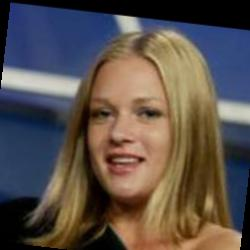

In [ ]:
#define display_image function
from IPython.display import Image, display
Image(filename=filenames[0]) 

Once we have indexed the images, we now search the data using the knn query type.

In [ ]:
#let's get the top 5 results. The first one will be of course the queried image itself 
k = 5
res = client.search(request_timeout=30, index=index,
                body={'size': k, 
                      'query': {'knn': {'lfw_img_vector': {'vector': feature_list[0], 'k': k}}}})


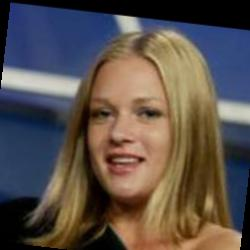

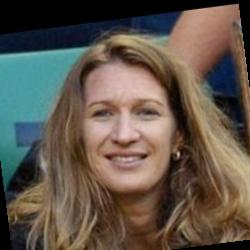

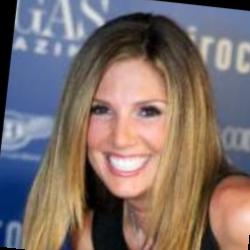

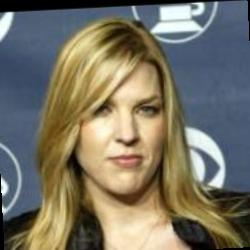

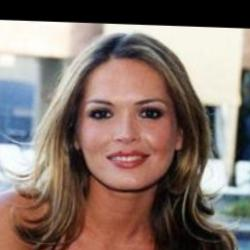

In [ ]:
#let's display the results in order
for i in range(k):
    location = res['hits']['hits'][i]['_source']['image']
    display(Image(filename=location))


# Task 2: Facenet embeddings

1 Let's upload the embeddings computed locally

In [ ]:
facenet_embeddings = load_pickle('Reverse Image Project/saved/features-facenet-normalized.pickle')[0]

2 let's create a new index

In [ ]:
#Define KNN Elasticsearch index maping
knn_index = {
    "settings": {
        "index.knn": True,
        'translog.flush_threshold_size': '10gb',
        'number_of_replicas': 0   
    },
    "mappings": {
        "properties": {
            "lfw_img_vector": {
                "type": "knn_vector",
                "dimension": 128 #embeddings size for facenet
            }
        }
    }
}

index = 'idx_facenet'

In [ ]:
#Creating the Elasticsearch index
client.indices.create(index=index,body=knn_index)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'idx_facenet'}

In [ ]:
#import images to elasticsearch, it will take around 2 minutes 
for i in range(len(facenet_embeddings)):
    res = client.index(index=index,
             body={"lfw_img_vector": facenet_embeddings[i], 
                   "image": filenames[i]},
            request_timeout=30
            )
res
    

{'_index': 'idx_facenet',
 '_type': '_doc',
 '_id': '5jHMd4ABSRpjtxzRL4_z',
 '_version': 1,
 'result': 'created',
 '_shards': {'total': 1, 'successful': 1, 'failed': 0},
 '_seq_no': 13232,
 '_primary_term': 1}

In [ ]:
#let's get the top 5 results. The first one will be of course the queried image itself 
k = 5
res = client.search(request_timeout=30, index=index,
                body={'size': k, 
                      'query': {'knn': {'lfw_img_vector': {'vector': facenet_embeddings[0], 'k': k}}}})

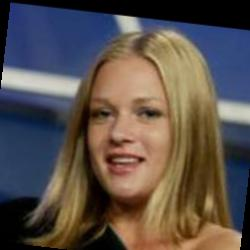

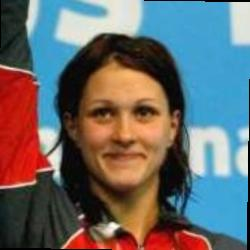

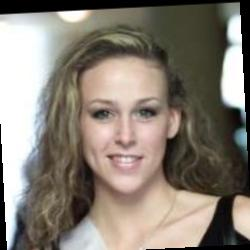

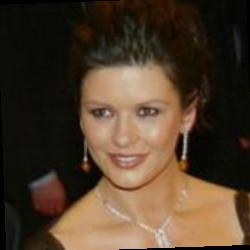

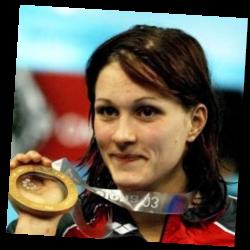

In [ ]:
for i in range(k):
    location = res['hits']['hits'][i]['_source']['image']
    display(Image(filename=location))

## Testing top 10 faces

- Pic 1 Alberto costa: index 209 
- Pic 2 Angela Bassett: index 642
- Pic 3 Arminio Fraga: index 901
- Pic 4 Billy_Crystal: index 1338
- Pic 5 Bob_Graham: index 1390
- Pic 6 Boris Becker: index 1445
- Pic 7 Bulent_Ecevit: index 1601
- Pic 8 Calista_Flockhart: index 1616
- Pic 9 Cameron_Diaz: index 1624  
- Pic 10 Carmen_Electra: index 1751

In [ ]:
faces = [209,642,901,1338,1390,1445,1601,1616,1624,1751] #these are indexes of the faces we want to test

###  Let's see the result

In [ ]:
#returns location of top k results given a query and an index for ES
def search(k,query,index):
    res = client.search(request_timeout=30, index=index,
                    body={'size': k, 
                          'query': {'knn': {'lfw_img_vector': {'vector': query, 'k': k}}}})

        
    return [res['hits']['hits'][i]['_source']['image'] for i in range(k)]

In [ ]:
#let's get the queries with resnet50
result_res = []
[result_res.append(search(20,feature_list[i],'idx_lfw')) for i in faces]
len(result_res)


10

In [ ]:
#let's get the queries with facenet
result_face = []
[result_face.append(search(20,facenet_embeddings[i],'idx_facenet')) for i in faces]
len(result_face)


    

10

Let's plot at group of 5 queries. Each column it's a query.

## FaceNet Model Results

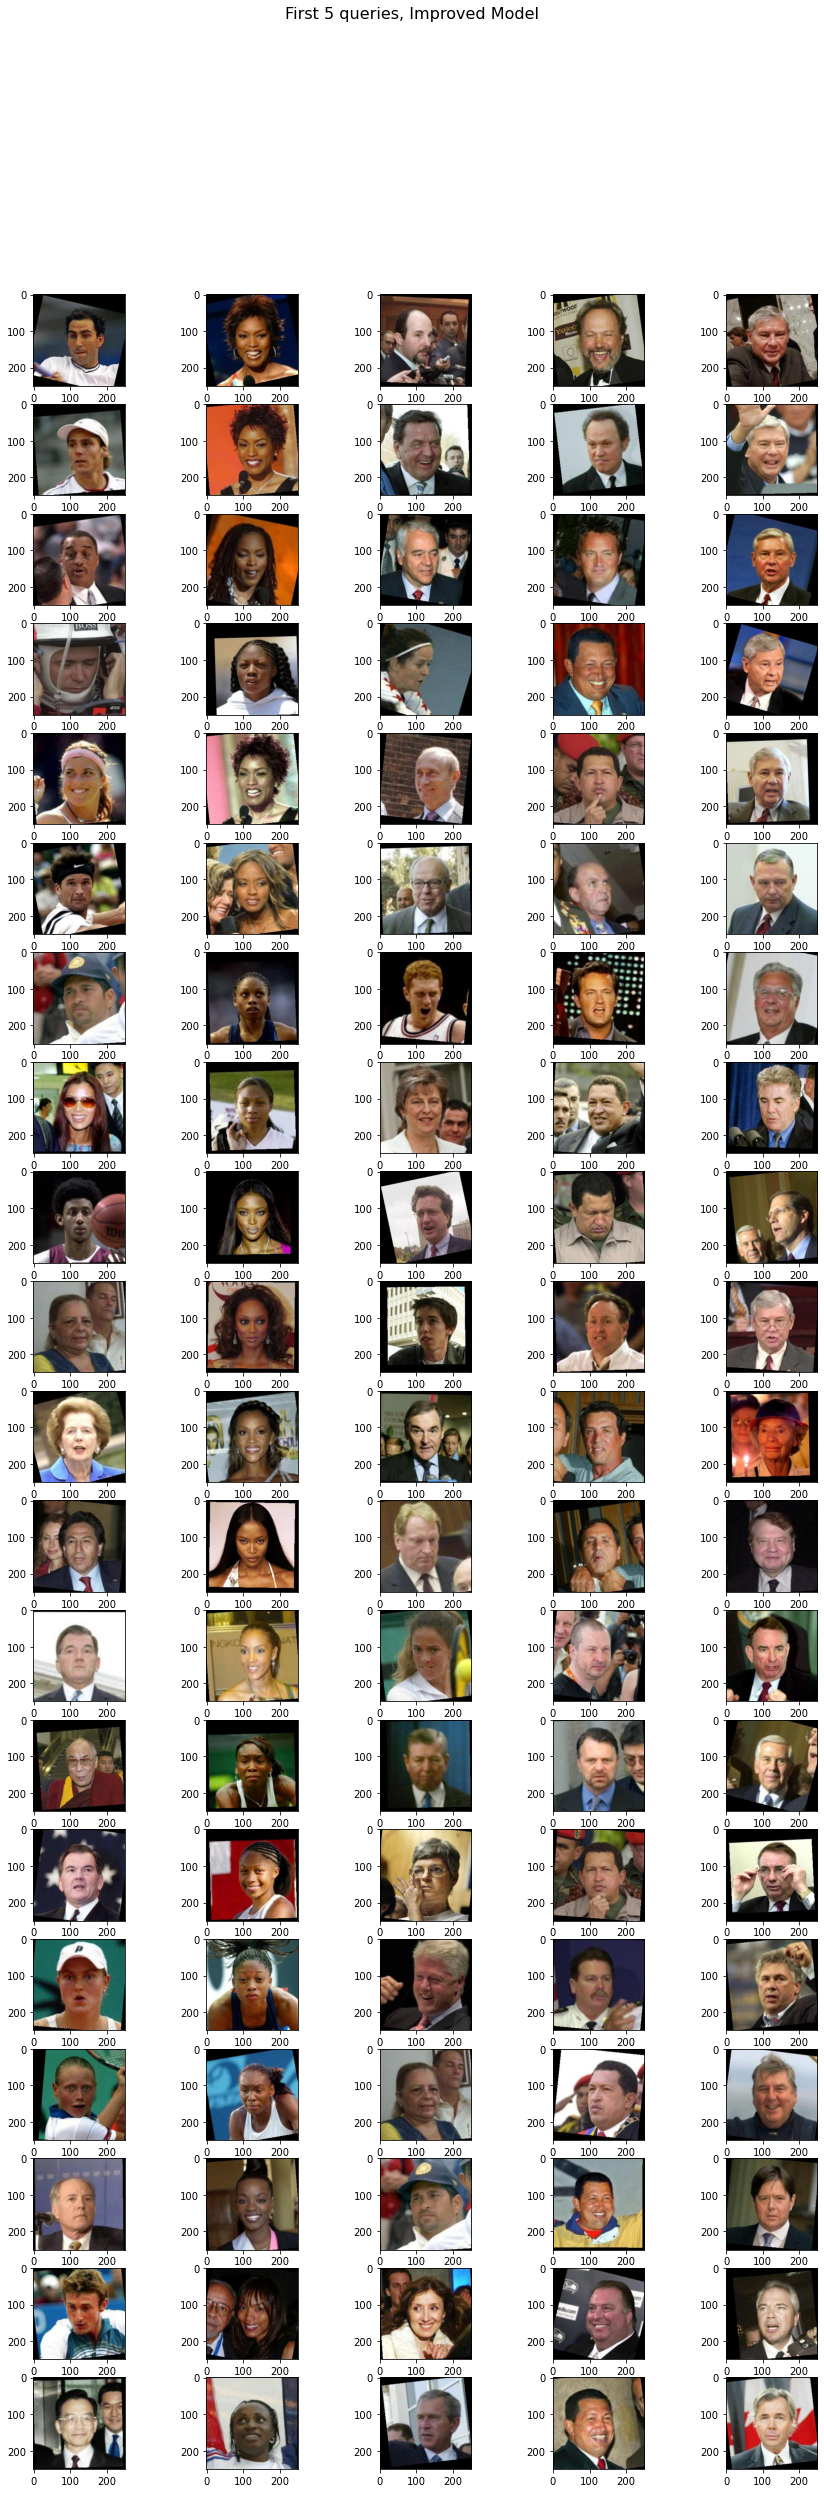

In [ ]:
#plotting the first 5 queries with facenet
import matplotlib.pyplot as plt

f, ax_arr = plt.subplots(20, 5, figsize=(15,40))

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        image = plt.imread(result_face[i][j])
        ax.imshow(image)

title = 'First 5 queries, Improved Model'
f.suptitle(title, fontsize=16)
plt.savefig('face1-5.png')
plt.show() 

 

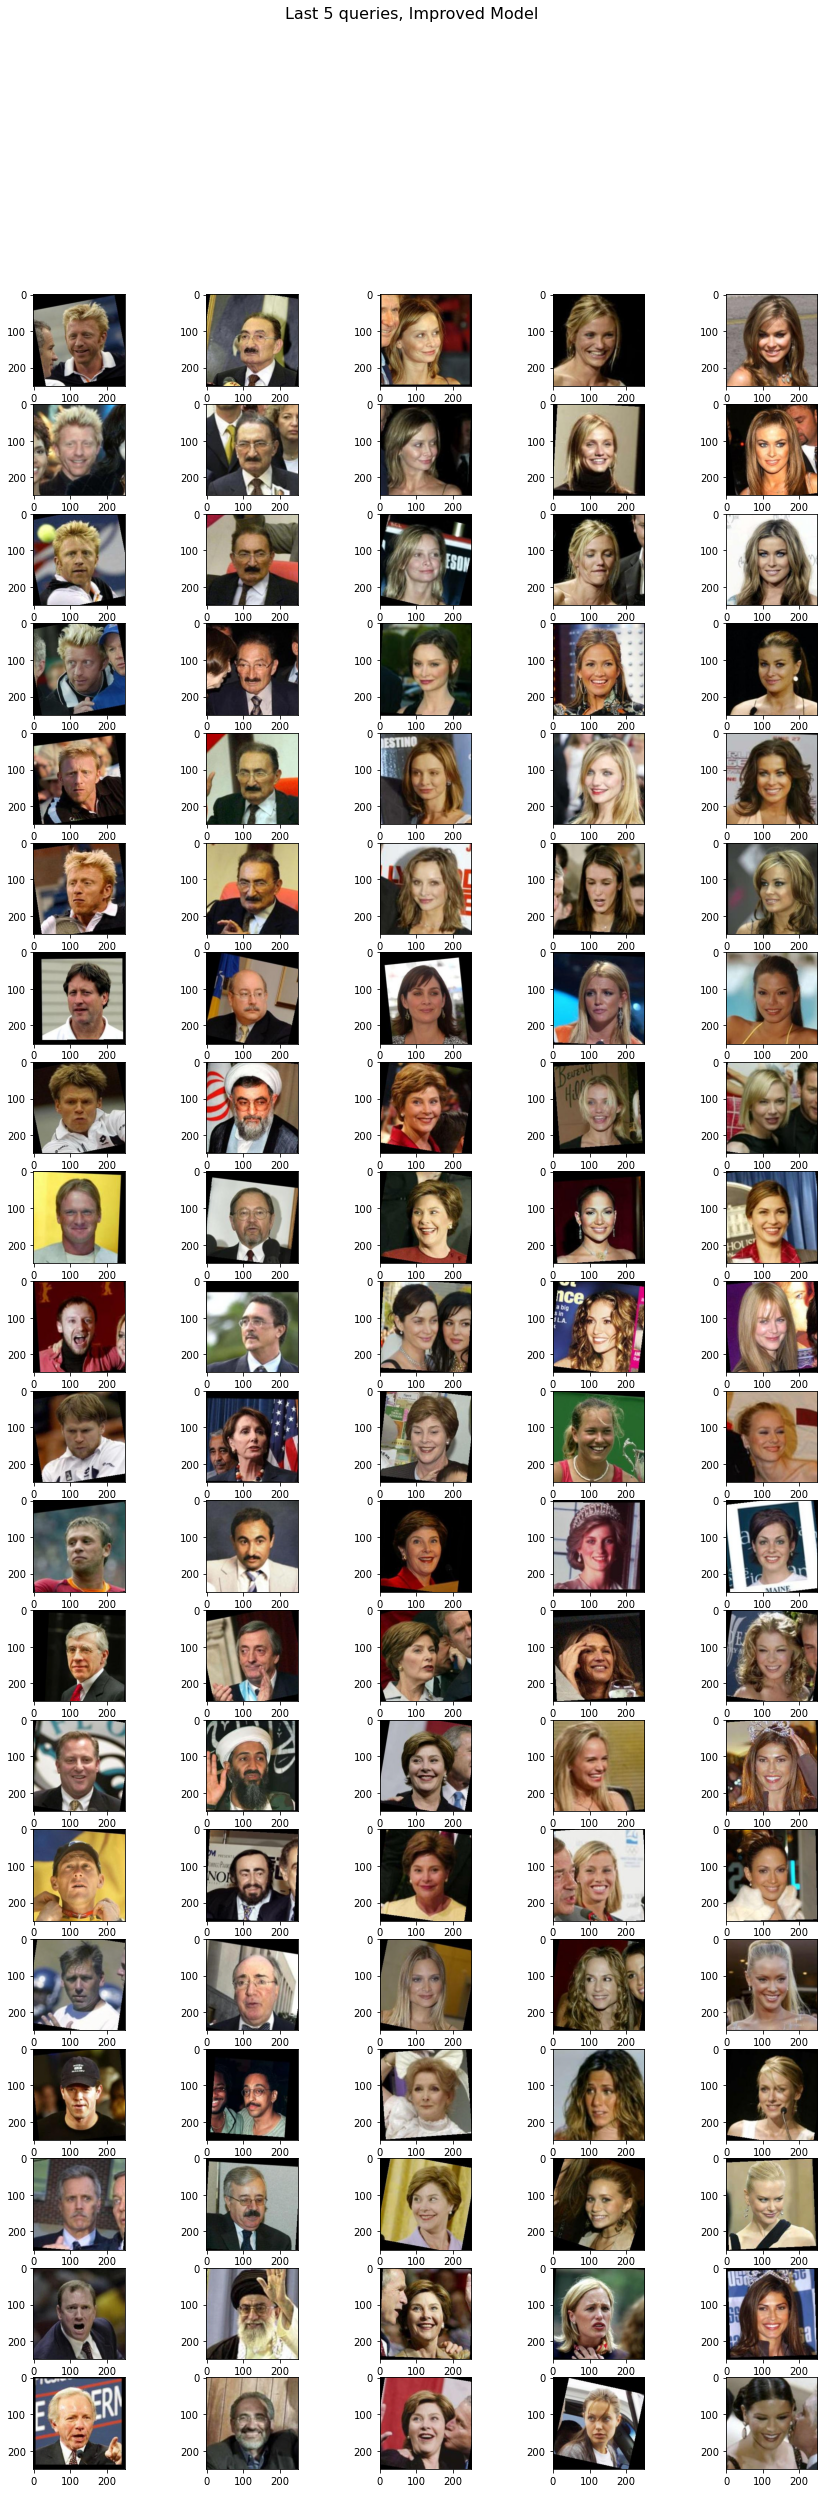

In [ ]:
#plotting the last 5 queries with facenet

result_face2 = result_face[5:]

f, ax_arr = plt.subplots(20, 5, figsize=(15,40))

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        image = plt.imread(result_face2[i][j])
        ax.imshow(image)

title = 'Last 5 queries, Improved Model'
f.suptitle(title, fontsize=16)
plt.savefig('face6-10.png')
plt.show() 

## Baseline Model Results

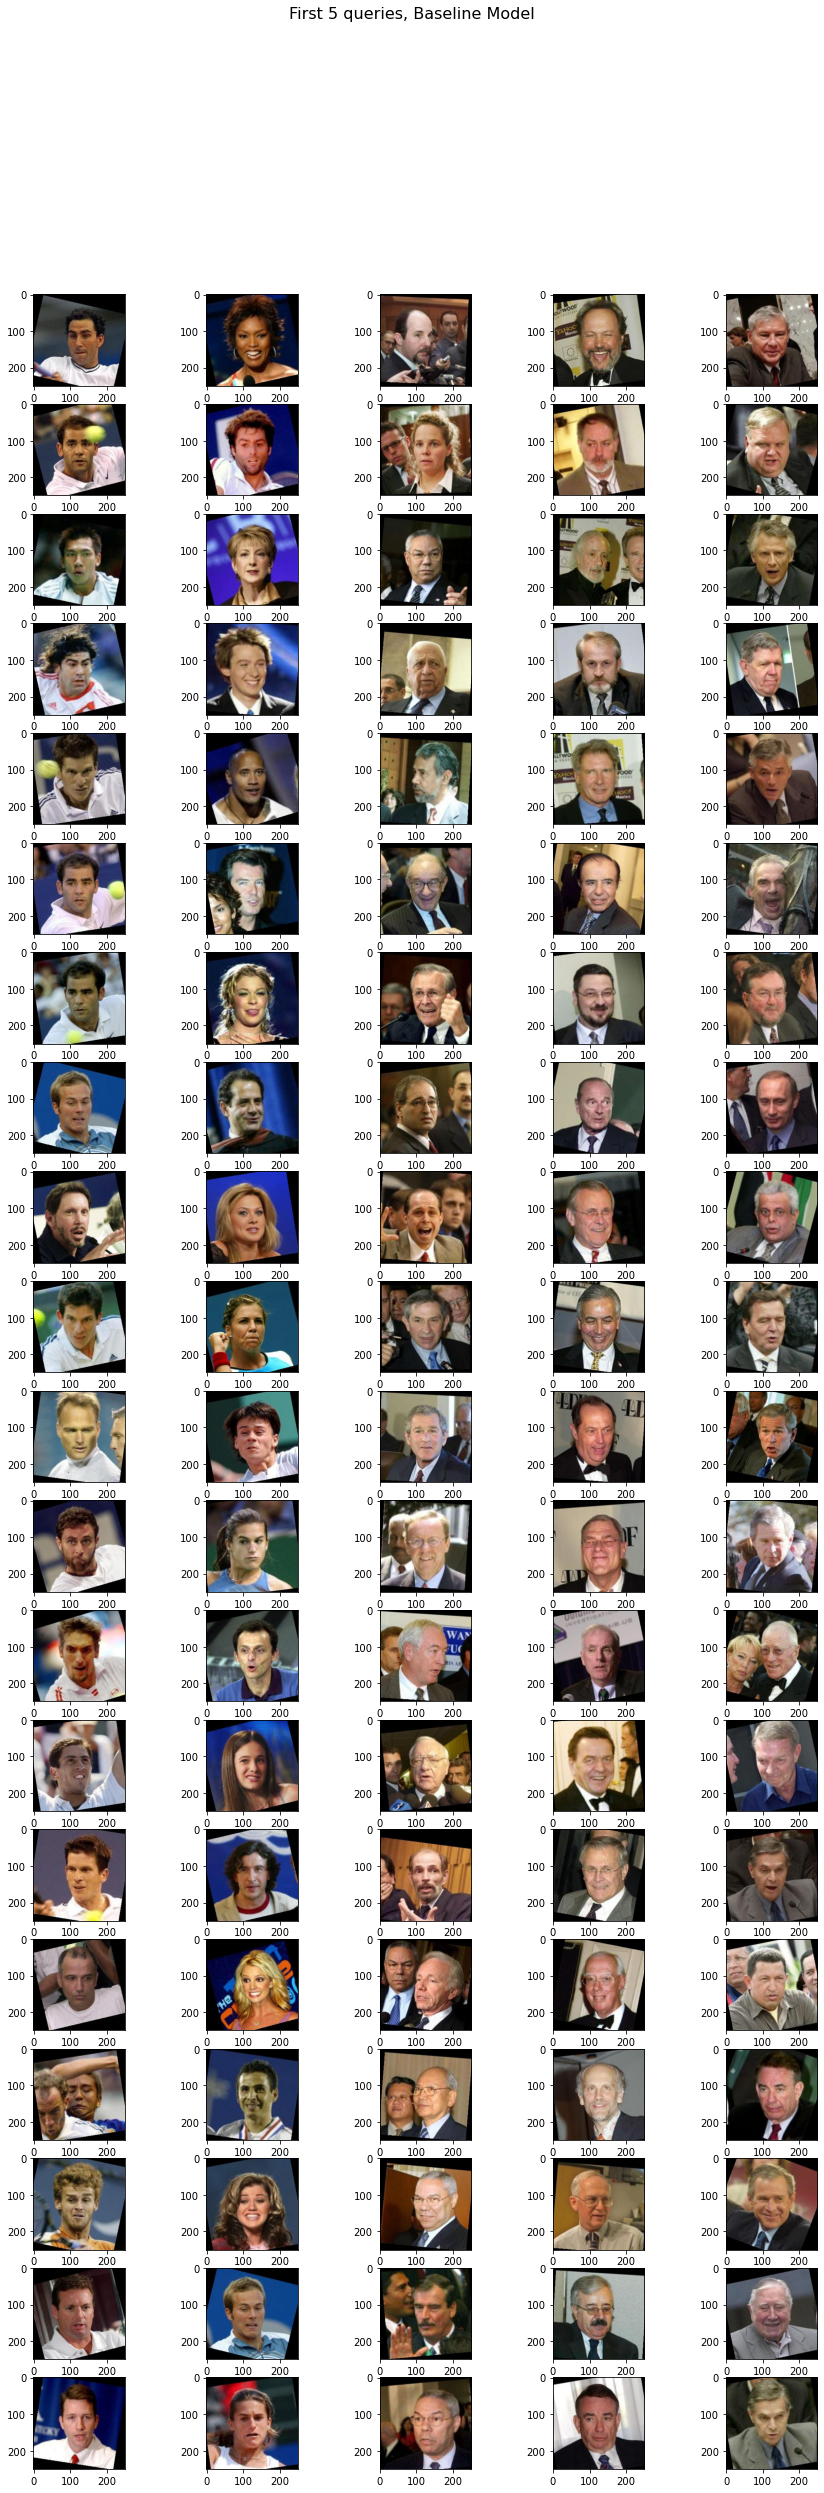

In [ ]:
#plotting the first 5 queries with the baseline model

f, ax_arr = plt.subplots(20, 5, figsize=(15,40))

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        image = plt.imread(result_res[i][j])
        ax.imshow(image)

title = 'First 5 queries, Baseline Model'
f.suptitle(title, fontsize=16)
plt.savefig('baseline1-5.png')
plt.show() 

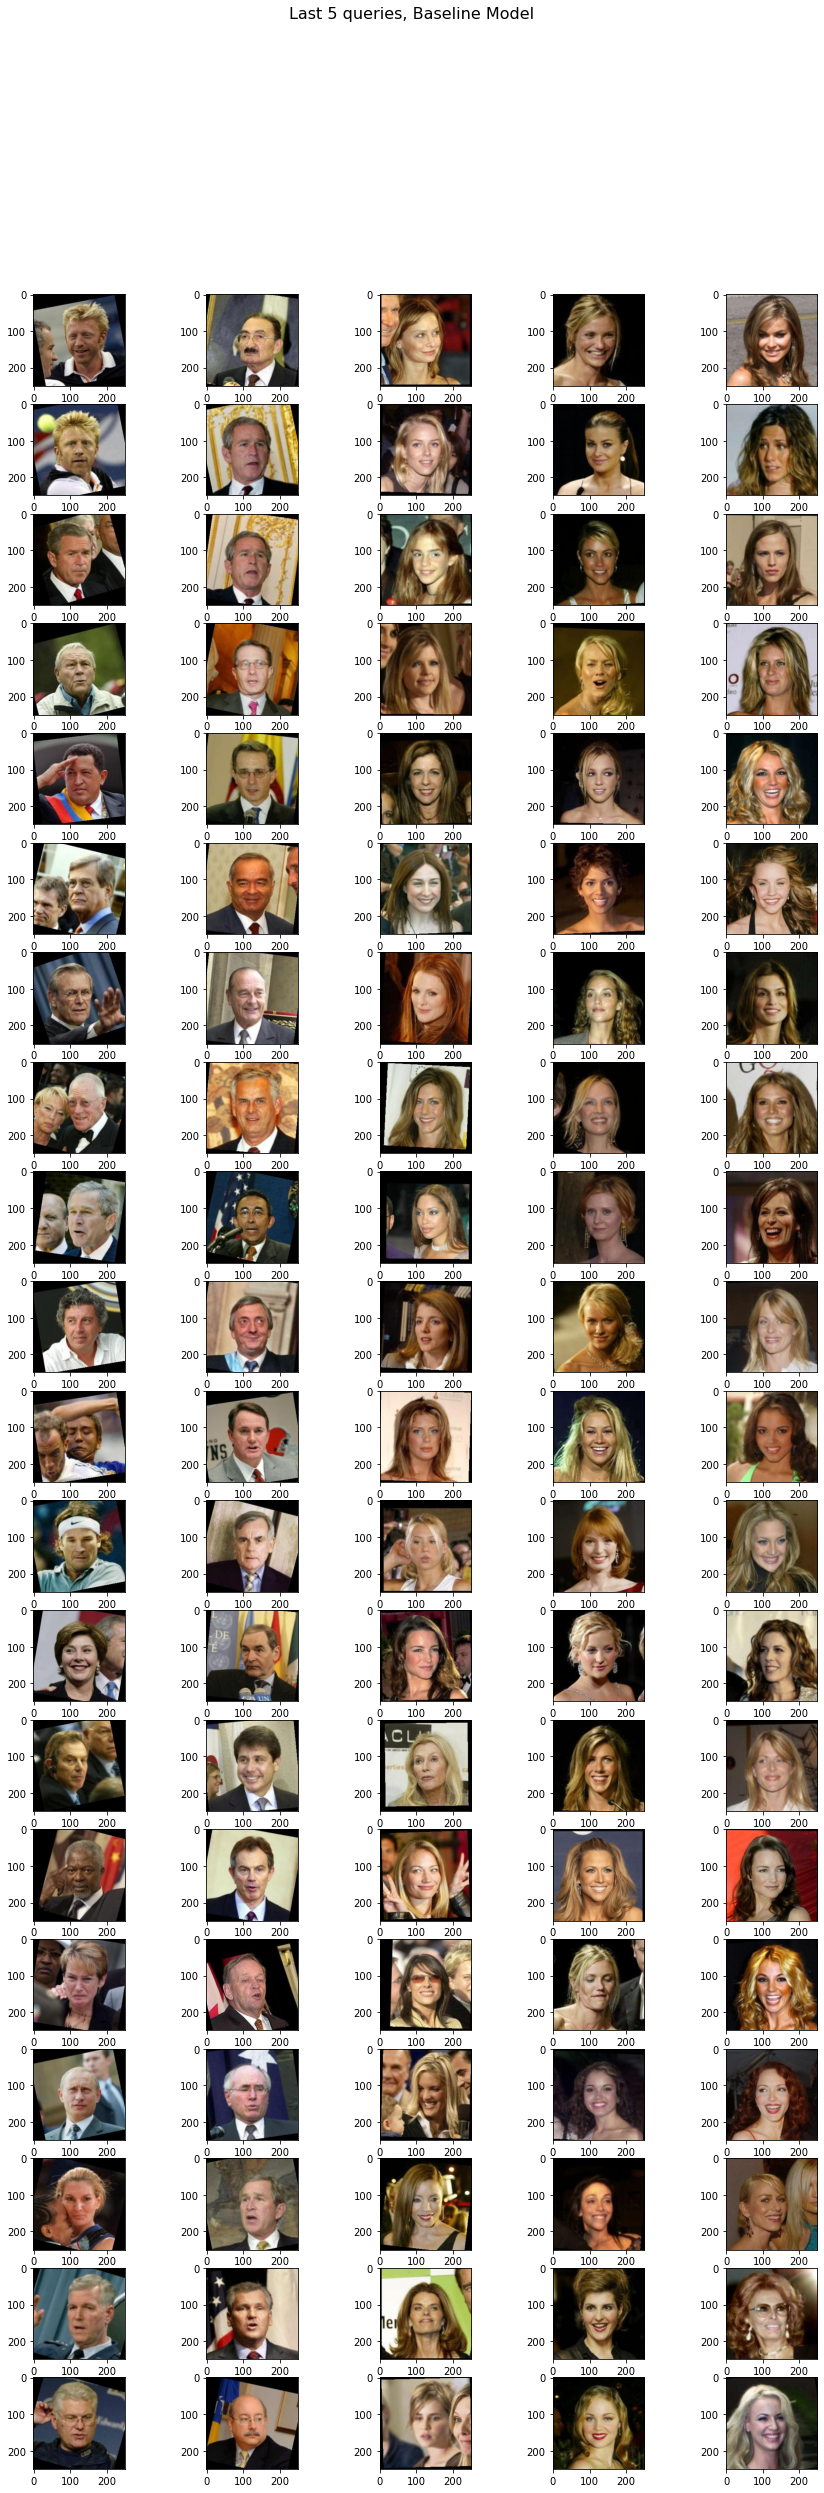

In [ ]:
#plotting the first 5 queries with the baseline model
result_res2 = result_res[5:]

f, ax_arr = plt.subplots(20, 5, figsize=(15,40))

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        image = plt.imread(result_res2[i][j])
        ax.imshow(image)

title = 'Last 5 queries, Baseline Model'
f.suptitle(title, fontsize=16)
plt.savefig('baseline6-10.png')
plt.show() 

## Conclusion

As we see, the FaceNet Model performs better than the baseline model of ResNet50. The difference between the Facenet embeddings and the pretrained resnet50 is substantial. The baseline model (resnet50) finds the overall image similarity: background, hair color, objects held, number of people in the picture and so on. 

Facenet on the other hand focuses on the facial characteristics. FaceNet is able to determine faces despite of occlusion, different angles/lightings and facial expressions. Thus, performs better and gives efficient results.